**Import and Setup**

In [1]:
import random
random.seed(42)

In [2]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define the path to the dataset and print contents to verify folder structure
data_dir = '/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image'
print(os.listdir(data_dir))  

# Define class labels
label_dict = {'Normal': 0, 'Lung_Opacity': 1, 'Viral Pneumonia': 2} 

# Store image paths and their corresponding labels
image_paths = []
labels = []

# Loop through each class to collect images and labels
for class_name in label_dict.keys():
    class_folder = os.path.join(data_dir, class_name)

    # Check if the folder exists and list files
    if os.path.exists(class_folder):
        for filename in os.listdir(class_folder):
            if filename.endswith('.jpg'):
                image_paths.append(os.path.join(class_folder, filename))
                labels.append(label_dict[class_name])
    else:
        print(f"Folder {class_folder} does not exist.")

# Print a few image paths and labels to verify
print(image_paths[:5])  
print(labels[:5])       


['Normal', 'Lung_Opacity', 'Viral Pneumonia']
['/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/623.jpg', '/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/764.jpg', '/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/1075.jpg', '/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/771.jpg', '/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/208.jpg']
[0, 0, 0, 0, 0]


**Preprocessing**

In [4]:
from sklearn.model_selection import train_test_split

# Dataset splitting into 70% train, 15% validation, and 15% test
# First, split into 70% train and 30% (validation + test)
train_paths, val_test_paths, train_labels, val_test_labels = train_test_split(
    image_paths, labels, test_size=0.30, random_state=42, stratify=labels
)

# Then, split the remaining 30% into 15% validation and 15% test
val_paths, test_paths, val_labels, test_labels = train_test_split(
    val_test_paths, val_test_labels, test_size=0.5, random_state=42, stratify=val_test_labels
)

# Verifying the splits
print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Testing samples: {len(test_paths)}")


Training samples: 2432
Validation samples: 521
Testing samples: 522


In [5]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Set device (to use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load pre-trained ResNet-18 model
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze the earlier layers of the ResNet model selectively (freeze first few layers)
# Keep layers from 'layer4' (deeper layers) trainable for fine-tuning
for name, param in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True  # Fine-tune the last layer and deeper blocks
    else:
        param.requires_grad = False  # Freeze all earlier layers

# Modify the final fully connected layer for the 3 classes 
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3) 

# Move the model to GPU if available
model = model.to(device)

# Print model to confirm layer freezing
print("Layer Freezing Status:")
for name, param in model.named_parameters():
    print(f'{name}: {"Trainable" if param.requires_grad else "Frozen"}')


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s] 


Layer Freezing Status:
conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: Frozen
layer2.0.conv2.weight: Frozen
layer2.0.bn2.weight: Frozen
layer2.0.bn2.bias: Frozen
layer2.0.downsample.0.weight: Frozen
layer2.0.downsample.1.weight: Frozen
layer2.0.downsample.1.bias: Frozen
layer2.1.conv1.weight: Frozen
layer2.1.bn1.weight: Frozen
layer2.1.bn1.bias: Frozen
layer2.1.conv2.weight: Frozen
layer2.1.bn2.weight: Frozen
layer2.1.bn2.bias: Frozen
layer3.0.conv1.weight: Frozen
layer3.0.bn1.weight: Frozen
layer3.0.bn1.bias: Frozen
layer3.0.conv2.weight: Frozen
layer3.0.bn2.weight: Froz

**Data Augmentation**

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Define transforms for data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for pre-trained ResNet
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom dataset class to load images and apply transformations
class LungDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')  # Convert to RGB as medical images are 3-channel
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create datasets for training, validation, and testing
train_dataset = LungDiseaseDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = LungDiseaseDataset(val_paths, val_labels, transform=val_test_transforms)
test_dataset = LungDiseaseDataset(test_paths, test_labels, transform=val_test_transforms)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check data loader batch outputs (optional)
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")


Batch shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])


**Class Imbalance Handling**

In [7]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import numpy as np

# Compute class weights for dealing with class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)


**Model Optimization**

In [8]:
import torch.optim as optim

# Define optimizer (Adam) and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay for regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
current_lr = scheduler.optimizer.param_groups[0]['lr']
print(f"Current learning rate: {current_lr}")


Current learning rate: 0.001


**Model Training, Validation, and Early Stopping with TensorBoard Integration**

In [9]:
import time
from torch.utils.tensorboard import SummaryWriter

# Function to train and validate the model
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=50, patience=10):
    writer = SummaryWriter()  # TensorBoard for visualization
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    patience_counter = 0  # For early stopping

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.cpu())

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        val_losses.append(val_loss)
        val_accs.append(val_acc.cpu())

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        writer.add_scalars('Loss', {'train': epoch_loss, 'val': val_loss}, epoch)

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        # Step scheduler based on validation loss
        scheduler.step(val_loss)

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# Train the model
model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=50)


Epoch 1/50
--------------------
Training Loss: 0.5292 Acc: 0.7924
Validation Loss: 0.2744 Acc: 0.8848
Epoch 2/50
--------------------
Training Loss: 0.3621 Acc: 0.8528
Validation Loss: 0.2567 Acc: 0.8906
Epoch 3/50
--------------------
Training Loss: 0.3188 Acc: 0.8721
Validation Loss: 0.2285 Acc: 0.9060
Epoch 4/50
--------------------
Training Loss: 0.3057 Acc: 0.8787
Validation Loss: 0.3222 Acc: 0.8752
Epoch 5/50
--------------------
Training Loss: 0.2707 Acc: 0.8914
Validation Loss: 0.2483 Acc: 0.9117
Epoch 6/50
--------------------
Training Loss: 0.2754 Acc: 0.8906
Validation Loss: 0.2663 Acc: 0.9021
Epoch 7/50
--------------------
Training Loss: 0.2894 Acc: 0.8820
Validation Loss: 0.2824 Acc: 0.8772
Epoch 8/50
--------------------
Training Loss: 0.2909 Acc: 0.8861
Validation Loss: 0.2217 Acc: 0.9079
Epoch 9/50
--------------------
Training Loss: 0.2555 Acc: 0.8923
Validation Loss: 0.2078 Acc: 0.9175
Epoch 10/50
--------------------
Training Loss: 0.2772 Acc: 0.8857
Validation Loss

**Visualizing Training and Validation Loss and Accuracy Curves**

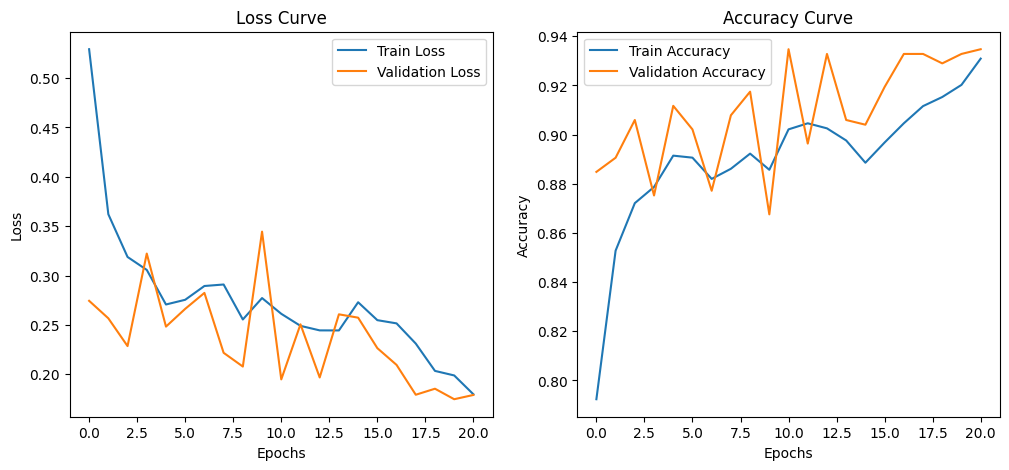

In [10]:
def plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot loss
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss Curve')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Accuracy Curve')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

# Plot results after training
plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs)


**Model Evaluation**

Precision (weighted): 0.9298
Recall (weighted): 0.9291
F1 Score (weighted): 0.9291

Classification Report:
                 precision    recall  f1-score   support

         Normal       0.89      0.92      0.91       188
   Lung_Opacity       0.95      0.90      0.92       169
Viral Pneumonia       0.95      0.97      0.96       165

       accuracy                           0.93       522
      macro avg       0.93      0.93      0.93       522
   weighted avg       0.93      0.93      0.93       522



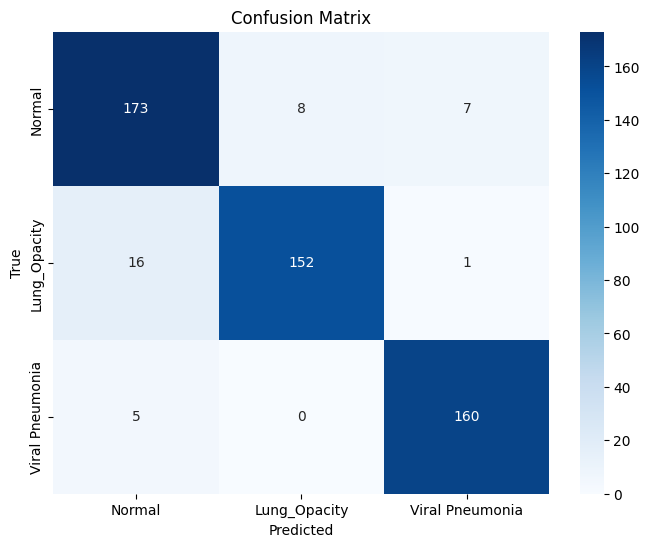

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate model on the test set and compute metrics
def test_model_with_metrics(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    # Collect predictions and ground truths
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted to account for class imbalance
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_dict.keys()))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
test_model_with_metrics(model, test_loader)


In [12]:
# Save the trained model
model_save_path = 'resnet18_lung_disease_model.pth'
torch.save(model.state_dict(), model_save_path)

# confirm the save
print(f"Model saved to {model_save_path}")


Model saved to resnet18_lung_disease_model.pth
